# **Neural Machine Translation - German to English**

# 1. Importing Libraries

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import os
import io
import string
import unicodedata
from unicodedata import normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from sklearn.model_selection import train_test_split


# 2. Loading the data

In [ ]:
!unzip '/content/drive/MyDrive/NMT/deu-eng.zip' -d '/content/drive/MyDrive/NMT'

Archive:  /content/drive/MyDrive/NMT/deu-eng.zip
  inflating: /content/drive/MyDrive/NMT/deu.txt  
  inflating: /content/drive/MyDrive/NMT/_about.txt  


Below is a tokenizer class that wraps the Keras' Tokenizer with additional functionalities. 

1. Reverse source langauge sequences
2. Create a mapping from Index to word
3. Convert tokens to string
4. Convert token to word
5. Text to tokens with reversal and padding

In [3]:
class TokenizerWrap(Tokenizer):

  def __init__(self, lang, padding, reverse=False, num_words=None):

    # Call base class' constructor
    Tokenizer.__init__(self, num_words=num_words)

    self.fit_on_texts(lang)

    # Inverse lookup
    self.index_to_word = dict(zip(self.word_index.values(),self.word_index.keys()))

    self.tensor = self.texts_to_sequences(lang)


    if reverse:
      self.tensor = [list(reversed(seq)) for seq in self.tensor]
      truncating ='pre'

    else:
      truncating = 'post'

    
    self.num_tokens = [len(seq) for seq in self.tensor]

    # Find the maximum length of a sequence
    self.max_len_tokens = np.mean(self.num_tokens) + 2* np.std(self.num_tokens)

    self.max_len_tokens = int(self.max_len_tokens)
    # Pad the tokens to the maximum length
    self.padded_tensor =  pad_sequences(self.tensor, maxlen=self.max_len_tokens, padding=padding, truncating=truncating)
                                        
  
  def token_to_word(self, token):
    ''' Converts an integer token to its corresponding word, if it exists    '''

    if token==0:
      word = " "
    else:
      word = self.index_to_word[token]

    return word

  def tokens_to_string(self, tokens, reverse=False):
    ''' Converts a list of integer tokens to their corresponding text sequence  '''

    words = [self.index_to_word[token] for token in tokens if token!=0]

    if reverse:
      words.reverse()

    text = " ".join(words)

    return text

 
  def text_to_tokens(self, text, reverse=False, padding=False):

   ''' Converts text to tokens with reversal and padding '''

   tokens = self.texts_to_sequences([text])
   tokens = np.array(tokens)

   if reverse:
     tokens = np.flip(tokens,axis=1)

     truncating = 'pre'

   else:
     truncating = 'post'

   
   if padding:

     tokens = pad_sequences(tokens, self.max_len_tokens, padding=True, truncating=True)
   return tokens



A class called Data which is used to read the file, load the data, preprocess the text and return the tensors for source and target language.





In [4]:
class Data:

  def __init__(self, langType):

    self.langType = 'deu-eng'
    self.input_tokenizer = None
    self.target_tokenizer = None


  def preprocess_sentence(self, sentence):

    #To remove non-printable characters
    re_printable = re.compile('[^%s]' % re.escape(string.printable))

    #Translation table to remove punctuation
    transTable = str.maketrans('','',string.punctuation)

    #Unicode Normalize sentence 
    sentence = normalize('NFD', sentence).encode('ascii','ignore')
    sentence = sentence.decode('UTF-8')

    sentence = sentence.split()
    # Convert to lower case
    sentence = [word.lower() for word in sentence]
    # Remove punctuations
    sentence = [word.translate(transTable) for word in sentence]
    # Remove Non-printable characters
    sentence = [re_printable.sub('',word) for word in sentence]
    # Remove tokens that are numbers
    sentence = [word for word in sentence if word.isalpha()]

    # Convert list of words to a string
    processedSentence = ' '.join(sentence)

    processedSentence = 'ssss ' + processedSentence + ' eeee'

    return processedSentence

  def tokenize(self, lang, padding, reverse, num_words):

    lang_tokenizer = TokenizerWrap(lang, padding, reverse, num_words=num_words)

    return lang_tokenizer.padded_tensor, lang_tokenizer
    


  def readFile(self, path, num_sentences):

    ''' read and preprocess sentences in the file '''

    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    sentence_Pairs = [[self.preprocess_sentence(s) for s in l.split('\t')[:2]]  for l in lines[:num_sentences]]

    sentencePairs = []

    #Reverse each pair in sentencePairs ( We need German -> English mapping)
    for pair in sentence_Pairs:
        pair.reverse()
        sentencePairs.append(pair)


    return zip(*sentencePairs)



  def loadDataset(self, file_path, num_sentences):

    ''' Create and return tensors and tokenizers'''

    input_sentences, target_sentences = self.readFile(file_path, num_sentences)

    input_tensor, input_tokenizer = self.tokenize(input_sentences, padding='pre', reverse=True, num_words=20000)
    
    target_tensor, target_tokenizer = self.tokenize(target_sentences, padding='post', reverse=False, num_words=20000)
    


    return input_tensor, target_tensor, input_tokenizer, target_tokenizer 
    
  
  def createDataset(self, file_path, num_sentences, buffer_size, batch_size):

    filePath = file_path
    input_tensor, target_tensor, self.input_tokenizer, self.target_tokenizer = self.loadDataset(filePath, num_sentences)

    input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size = 0.2)
  
    train_data = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train))
    train_data = train_data.shuffle(buffer_size).batch(batch_size,drop_remainder=True)

    test_data = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test))
    test_data = test_data.batch(batch_size, drop_remainder=True)

    return train_data, test_data, self.input_tokenizer, self.target_tokenizer




In [5]:
dataObject = Data('deu-eng')
batch_size = 64
buffer_size = 32000
num_sentences = 30000

train_data, test_data, input_tokenizer, target_tokenizer = dataObject.createDataset('/content/drive/MyDrive/NMT/deu.txt',num_sentences, buffer_size, batch_size)

Let us look at a tensor..

In [6]:
sample_input, sample_target = next(iter(train_data))



text_s = input_tokenizer.tokens_to_string(sample_input[3].numpy(), reverse=True) # Indexing using tensor[0].numpy()
text_t = target_tokenizer.tokens_to_string(sample_target[3].numpy())
print("Source : ")
print(sample_input.shape)
print(text_s)

print("Target")
print(sample_target.shape)
print(text_t)

Source : 
(64, 7)
ssss lass es tom machen eeee
Target
(64, 6)
ssss let tom do it eeee


Setting some important parameters

In [7]:
input_vocab_size = len(input_tokenizer.word_index)+1
target_vocab_size = len(target_tokenizer.word_index)+1

input_max_length = sample_input.shape[1]
target_max_length = sample_target.shape[1]

embedding_size = 256
num_hidden_units = 1024
steps_per_epoch = num_sentences/batch_size


In [ ]:
print("Size of German vocabulary : ", input_vocab_size)
print("Size of English vocabulary : ", target_vocab_size)

Size of German vocabulary :  7285
Size of English vocabulary :  4620


# 3. Building the Encoder and Decoder

Below is the implementation of Encoder stack :

In [8]:
class Encoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_size, state_size, batch_size):

    super(Encoder, self).__init__()

    self.state_size = state_size
    self.embedding_size = embedding_size
    self.batch_size = batch_size

    # An Embedding layer followed by three LSTM layers in the Encoder
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
    self.lstm1 = tf.keras.layers.LSTM(state_size, return_sequences=True)
    self.lstm2 = tf.keras.layers.LSTM(state_size, return_sequences=True)
    self.lstm3 = tf.keras.layers.LSTM(state_size, return_sequences=True, return_state=True)

  
  #Function to make a forward pass through the encoder, given a batch of input tokens
  def call(self, input):

    embedding = self.embedding(input)

    out = self.lstm1(embedding)
    out = self.lstm2(out)
    out, h, c = self.lstm3(out)

    return out, h, c


In [9]:
encoder = Encoder(input_vocab_size, embedding_size, num_hidden_units, batch_size)

sample_out, sample_h, sample_c = encoder(sample_input)

print(sample_out.shape)
print(sample_h.shape)
print(sample_c.shape)

(64, 7, 1024)
(64, 1024)
(64, 1024)


Below is the implementation of Decoder stack

**Bahadanau Attention Layer**

In [10]:
class BahdanauAttention(tf.keras.layers.Layer):

  def __init__(self, num_units):

    super(BahdanauAttention, self).__init__()

    self.W1 = tf.keras.layers.Dense(num_units)
    self.W2 = tf.keras.layers.Dense(num_units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, encoder_output, previous_hidden):

    previous_hidden = tf.expand_dims(previous_hidden, axis=1)

    alignment_score = self.V(tf.nn.tanh(self.W1(encoder_output) + self.W2(previous_hidden)))

    attention_weights = tf.nn.softmax(alignment_score, axis=1)

    context_vector = attention_weights*encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)

context_vector, attention_weights = attention_layer(sample_out, sample_h)


print('Context Vector shape : ', context_vector.shape)
print('Attention weights shape : ', attention_weights.shape)

Context Vector shape :  (64, 1024)
Attention weights shape :  (64, 7, 1)


**Decoder with Attention mechanism**

In [11]:
class Decoder(tf.keras.Model):

  def __init__(self, vocab_size, embedding_size, state_size, batch_size):

    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.num_units = state_size

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)

    self.lstm = tf.keras.layers.LSTM(self.num_units, return_sequences=True, return_state=True)

    self.dense = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.num_units)


  def call(self, input, previous_hidden, encoder_output):
    

    context_vector, attention_weights = self.attention(encoder_output, previous_hidden)
   
    input = self.embedding(input)
    
    input = tf.concat([tf.expand_dims(context_vector, 1), input], axis=-1)
    
    output, h, c = self.lstm(input)
   
    output = tf.reshape(output, (-1, output.shape[2]))
   
    output = self.dense(output)
    
    return output, h, attention_weights



In [12]:
decoder = Decoder(target_vocab_size, embedding_size, num_hidden_units, batch_size)

sample_decoder_output, _, _ = decoder(tf.random.uniform((batch_size, 1)), sample_h, sample_out)

print ('Decoder output' , sample_decoder_output.shape)

Decoder output (64, 4620)


# 4. Optimizer and Loss Function

In [13]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


def loss_function(truth, predicted):

  mask = tf.math.logical_not(tf.math.equal(truth, 0))

  loss = loss_object(truth, predicted)

  mask = tf.cast(mask, dtype=loss.dtype)

  loss = loss*mask

  return tf.reduce_mean(loss)

Checkpoints :




In [14]:
checkpoint_dir = './training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "chkpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

# 5. Training 

**Training using Teacher Forcing**

Training step over a single batch

In [15]:
def train(input_tensor, target_tensor):

  optimizer = tf.keras.optimizers.Adam()
  loss = 0.0

  with tf.GradientTape() as tape:

    batch_size = input_tensor.shape[0]

    encoder_output, encoder_hidden, encoder_cell = encoder(input_tensor)

    previous_hidden = encoder_hidden

    decoder_input = tf.expand_dims([target_tokenizer.word_index['ssss']]*batch_size,1)

    for t in range(1, target_tensor.shape[1]):

      predictions, previous_hidden, _ = decoder(decoder_input, previous_hidden, encoder_output)

      loss = loss + loss_function(target_tensor[:,t], predictions)

      # Teacher forcing
      decoder_input = tf.expand_dims(target_tensor[:,t],1)

  # Averaging over the length of the target sequences
  batch_loss = (loss / int(target_tensor.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


Training over multiple batches and epochs

In [16]:
epochs = 10

for epoch in range(epochs):

  total_loss = 0

  for (batch, (input_tensor,target_tensor)) in enumerate(train_data.take(int(steps_per_epoch))):

    batch_loss = train(input_tensor, target_tensor)

    total_loss = total_loss + batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
  # Save the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))

Epoch 1 Batch 0 Loss 6.1529
Epoch 1 Batch 100 Loss 3.9618
Epoch 1 Batch 200 Loss 3.4144
Epoch 1 Batch 300 Loss 3.2180
Epoch 1 Loss 2.9579
Epoch 2 Batch 0 Loss 3.4042
Epoch 2 Batch 100 Loss 3.2181
Epoch 2 Batch 200 Loss 3.0015
Epoch 2 Batch 300 Loss 3.0240
Epoch 2 Loss 2.4384
Epoch 3 Batch 0 Loss 3.0415
Epoch 3 Batch 100 Loss 2.6151
Epoch 3 Batch 200 Loss 2.6528
Epoch 3 Batch 300 Loss 2.6589
Epoch 3 Loss 2.1859
Epoch 4 Batch 0 Loss 2.6376
Epoch 4 Batch 100 Loss 2.3059
Epoch 4 Batch 200 Loss 2.5141
Epoch 4 Batch 300 Loss 2.5270
Epoch 4 Loss 1.9780
Epoch 5 Batch 0 Loss 2.1168
Epoch 5 Batch 100 Loss 2.1173
Epoch 5 Batch 200 Loss 2.3309
Epoch 5 Batch 300 Loss 2.3316
Epoch 5 Loss 1.8241
Epoch 6 Batch 0 Loss 2.0689
Epoch 6 Batch 100 Loss 1.9538
Epoch 6 Batch 200 Loss 2.0011
Epoch 6 Batch 300 Loss 2.2671
Epoch 6 Loss 1.7095
Epoch 7 Batch 0 Loss 1.7719
Epoch 7 Batch 100 Loss 1.8833
Epoch 7 Batch 200 Loss 2.1868
Epoch 7 Batch 300 Loss 2.0113
Epoch 7 Loss 1.6204
Epoch 8 Batch 0 Loss 1.8262
Epoch 

# 6. Testing and Evaluation

Testing on batches of test data

In [80]:
def test(input_tensor, target_tensor):

  val_loss = 0.0

  batch_size = input_tensor.shape[0]

  encoder_output, encoder_hidden, _ = encoder(input_tensor)

  decoder_hidden = encoder_hidden

  decoder_input = tf.expand_dims([target_tokenizer.word_index['ssss']]*batch_size, 1)

  for t in range(1, target_tensor.shape[1]):
    
    predictions, decoder_hidden, _ = decoder(decoder_input, decoder_hidden, encoder_output)
   
    val_loss += loss_function(target_tensor[:,t], predictions)
    
    decoder_input = tf.expand_dims(np.argmax(predictions, axis=1),1)

  batch_loss = (val_loss/int(target_tensor.shape[1]))
  return batch_loss


Evaluation on new sentences

In [96]:
def evaluate(sentence):

  attention_matrix = np.zeros((target_max_length, input_max_length))

  sentence = dataObject.preprocess_sentence(sentence)

  input_tokens = [input_tokenizer.word_index[i] for i in sentence.split(' ') if i in input_tokenizer.word_index.keys()]

  input_tokens = list(reversed(input_tokens))

  input_tokens = pad_sequences([input_tokens], maxlen=input_max_length, padding='pre', truncating='pre')

  input_tensor = tf.convert_to_tensor(input_tokens)
 

  translation = ''

  encoder_output, encoder_hidden, _ = encoder(input_tensor)

  decoder_input = tf.expand_dims([target_tokenizer.word_index['ssss']], 0)

  decoder_hidden = encoder_hidden

  for t in range(target_max_length):

    predictions, decoder_hidden, attention_weights = decoder(decoder_input, decoder_hidden, encoder_output)

    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_matrix[t] = attention_weights.numpy()

    predicted_index = tf.argmax(predictions[0]).numpy()

    translation += target_tokenizer.index_word[predicted_index] + ' '

    if target_tokenizer.index_word[predicted_index] == 'eeee':
      return translation, sentence, attention_matrix

    # The prediction is fed into the next time step of the decoder
    decoder_input = tf.expand_dims([predicted_index], 0)

  return translation, sentence, attention_matrix



In [19]:
def plot_attention_weights(attention, sentence, predicted_translation):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_translation, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [68]:
def translate(sentence):
  translation, sentence, attention_matrix = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(translation))

  attention_matrix = attention_matrix[:len(translation.split(' ')), :len(sentence.split(' '))]
  plot_attention_weights(attention_matrix, sentence.split(' '), translation.split(' '))

In [21]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [98]:
total_val_loss = 0
for (batch, (input_tensor, target_tensor)) in enumerate(test_data.take(int(steps_per_epoch))):
    val_batch_loss = test(input_tensor, target_tensor)

    total_val_loss += val_batch_loss

mean_loss = total_val_loss/int(steps_per_epoch)

print(mean_loss.numpy())

0.5352502


[2, 46, 8, 61, 37, 1]
[[ 0  2 46  8 61 37  1]]
Input: ssss wie geht es dir eeee
Predicted translation: how are you are eeee 


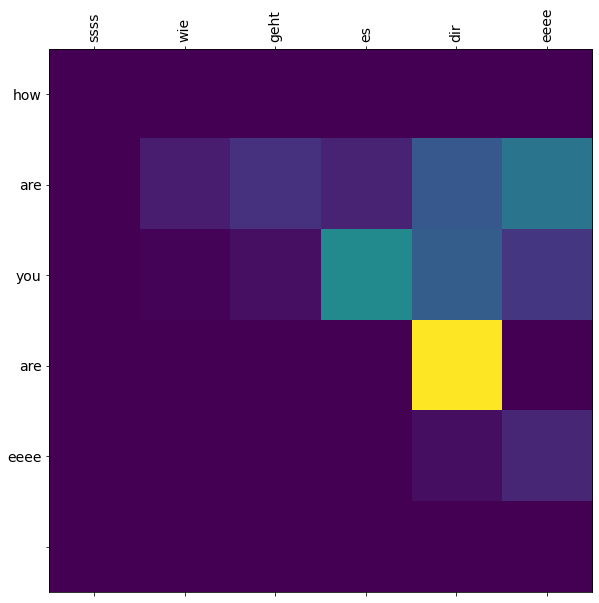

In [95]:
translate(u'Wie geht es dir')

[2, 72, 1471, 9, 64, 13, 1]
[[   2   72 1471    9   64   13    1]]
Input: ssss er will nicht darin verstrickt werden eeee
Predicted translation: he can not not in not 


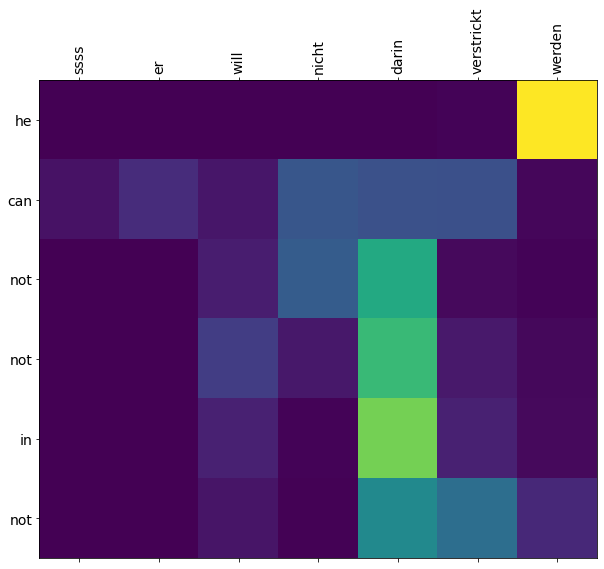

In [94]:
translate(u'Er will nicht darin verstrickt werden')